In [1]:
import tweepy
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
mpl.rcParams['font.family'] = "IPAexGothic"

## Gathering data

### Gethering from twitter

In [2]:
# Getting customer key and access token
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [3]:
# Getting api value
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [4]:
# Creating column list and searched tweet id
columns_name=["TW_NO","TW_TIME","TW_TEXT","FAV","RT"]
tw_id ='tarinaifutari'

In [5]:
# Creating DataFrame
tweet_data = []
for tweet in tweepy.Cursor(api.user_timeline,screen_name = tw_id,exclude_replies = True).items():
    tweet_data.append([tweet.id,tweet.created_at+datetime.timedelta(hours=9),tweet.text.replace('\n',''),tweet.favorite_count,tweet.retweet_count])
df = pd.DataFrame(tweet_data,columns=columns_name)

In [6]:
# Setting 80 characters in a column
pd.set_option("display.max_colwidth", 280)

In [7]:
df.head()

,TW_NO,TW_TIME,TW_TEXT,FAV,RT
0,1191011635109888000,2019-11-04 00:17:56,さよなら？いや、こんにちは。 https://t.co/kb0drHfsr9,6322,655
1,1190907650810118146,2019-11-03 17:24:44,ついていくしかないんでしょ？行くよ…文責山里,1801,158
2,1190903280357933056,2019-11-03 17:07:22,ノートの向こう側に連れて行ってあげるからね。楽しみにしててね。文責若林,2578,283
3,1190879051138781184,2019-11-03 15:31:05,ご指示の通りノート見てたから…文責山里,1192,84
4,1190872025595699201,2019-11-03 15:03:10,おい、この返しを見るに今日調子良さそうだな。文責若林,1760,120


### Checking the data

/Users/Waka/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


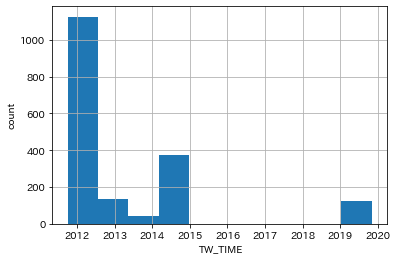

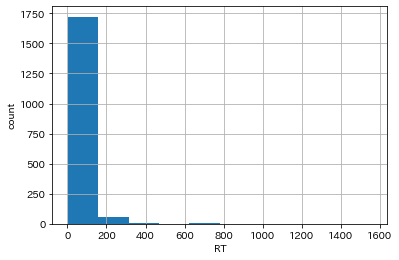

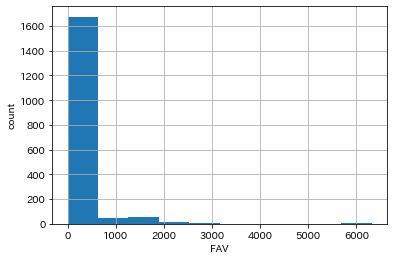

In [8]:
# Check the tweet year
for column in ["TW_TIME", "RT", "FAV"]:
    df[column].hist()
    plt.ylabel('count')
    plt.xlabel(column)
    plt.show();

## Wrangling data

### Deleting the space

In [9]:
# Delete the space in twitter text
df['TW_TEXT'] = df['TW_TEXT'].apply(lambda x: re.sub('([あ-んア-ン一-龥ー])\s+((?=[あ-んア-ン一-龥ー]))',r'\1\2', x))

### Creating new column "person"

In [10]:
# Create person column to clarify who tweeted.
# Firstly, I filtered the word "文責山里" and "文責若林" following their rule
df['PERSON'] ='不明'

for i in range(df.shape[0]):
    if '文責若林' in df.loc[i,'TW_TEXT']:
        df.loc[i, 'PERSON']='若林'
    elif '文責山里' in df.loc[i,'TW_TEXT'] :
        df.loc[i, 'PERSON']='山里'

In [11]:
# Modifying the filter
# ['文責山里若林', '文責山里・若林'] → 双方
for b_word in ['文責山里若林', '文責山里・若林']:
    for i in range(df.shape[0]):
        if b_word in df.loc[i,'TW_TEXT']:
            df.loc[i,'PERSON']='双方'

In [12]:
# Checking if the above change is working or not
df[df['PERSON']=='双方']['TW_TEXT'].count()

4

In [13]:
# Checking the tweet not following the rule
df[df['PERSON']=='不明']['TW_TEXT'].count()

538

In [14]:
# Checking the tweet not following the rule
df[df['PERSON']=='不明']['TW_TEXT'].head()

0                                                                                                            さよなら？いや、こんにちは。 https://t.co/kb0drHfsr9
35         RT @thetvjp: 「たりないふたり」5年ぶり復活で“さよなら”のワケ企画演出・安島隆氏が語る山里亮太×若林正恭の10年 #たりないふたり #たりふた #ライブ #山里亮太 #若林正恭 #安島隆 @tarinaifutari @takashiajimahttps:…
77     たりないふたりファンの方に現状報告です。2人で会える日がなく山ちゃんはスッキリの見守り終わり、ぼくは日テレのレギュラー番組の前に安島さんが楽屋にやって来て「ハロウィンなんかは今どう思う？」と聞かれてはそれを伝言しに行くというスタイ… https://t.co/rPpQ3HRBVm
160                                                                                                                  チュウ、チュウ、次がラストの収録。色々と企みチュウ。文責悪鼠
162                                                                                                                              チュウ、チュウ、ロケチュウ。文責悪鼠
Name: TW_TEXT, dtype: object

In [15]:
# Checking the other word which we can filter the person by.
# ['文責悪鼠', '歌責若林', 'MASA', '文責・若林', '文責若']　→ 若林
# ['山里亮太'] → 山里

for w_word in ['文責悪鼠', '歌責若林', 'MASA', '文責・若林', '文責若']:
    for i in range(df.shape[0]):
        if df.loc[i,'PERSON']=='不明':
            if w_word in df.loc[i,'TW_TEXT']:
                df.loc[i,'PERSON']='若林'

for i in range(df.shape[0]):
    if df.loc[i,'PERSON']=='不明':
        if '山里亮太' in df.loc[i,'TW_TEXT']:
            df.loc[i,'PERSON']='山里'

In [16]:
# Checking the tweet not following the rule
df[df['PERSON']=='不明']['TW_TEXT'].count()

512

### Creating new column "term"

In [17]:
df["TW_TIME"].dt.year.value_counts()

2012    1004
2014     419
2011     255
2019     124
Name: TW_TIME, dtype: int64

In [18]:
df.loc[(df["TW_TIME"].dt.year == 2011)|(df["TW_TIME"].dt.year == 2012), 'term']='term1'
df.loc[df["TW_TIME"].dt.year == 2014, 'term']='term2'
df.loc[df["TW_TIME"].dt.year == 2019, 'term']='term3'

In [19]:
df.head()

,TW_NO,TW_TIME,TW_TEXT,FAV,RT,PERSON,term
0,1191011635109888000,2019-11-04 00:17:56,さよなら？いや、こんにちは。 https://t.co/kb0drHfsr9,6322,655,不明,term3
1,1190907650810118146,2019-11-03 17:24:44,ついていくしかないんでしょ？行くよ…文責山里,1801,158,山里,term3
2,1190903280357933056,2019-11-03 17:07:22,ノートの向こう側に連れて行ってあげるからね。楽しみにしててね。文責若林,2578,283,若林,term3
3,1190879051138781184,2019-11-03 15:31:05,ご指示の通りノート見てたから…文責山里,1192,84,山里,term3
4,1190872025595699201,2019-11-03 15:03:10,おい、この返しを見るに今日調子良さそうだな。文責若林,1760,120,若林,term3


## Storing data into csv file

In [20]:
df.to_csv('tarifuta_analysis.csv', index=False)

## Analyzing data

### Reading csv file

In [21]:
df = pd.read_csv('tarifuta_analysis.csv')

In [22]:
df.head(3)

,TW_NO,TW_TIME,TW_TEXT,FAV,RT,PERSON,term
0,1191011635109888000,2019-11-04 00:17:56,さよなら？いや、こんにちは。 https://t.co/kb0drHfsr9,6322,655,不明,term3
1,1190907650810118146,2019-11-03 17:24:44,ついていくしかないんでしょ？行くよ…文責山里,1801,158,山里,term3
2,1190903280357933056,2019-11-03 17:07:22,ノートの向こう側に連れて行ってあげるからね。楽しみにしててね。文責若林,2578,283,若林,term3


### Analyzing1. Retweet and favorite count per Person and term

In [23]:
# Creating new DataFrame for counting favorite and retweet average
df_rt_fav=df.groupby(['PERSON', 'term'])[['RT', 'FAV']].mean().reset_index()

# Deleting "不明"(Unknown) and "双方"(both) in person column
df_rt_fav =df_rt_fav[~((df_rt_fav['PERSON']=='不明')|(df_rt_fav['PERSON']=='双方'))]

In [24]:
df_rt_fav

,PERSON,term,RT,FAV
5,山里,term1,19.625369,34.873156
6,山里,term2,37.248677,79.761905
7,山里,term3,145.456140,1263.543860
8,若林,term1,36.456938,52.440191
9,若林,term2,62.527523,149.233945
10,若林,term3,234.292308,1897.076923


In [25]:
# Comparing retweet average
for term in ['term1', 'term2', 'term3']:
    y_rt =df_rt_fav.loc[(df_rt_fav['PERSON']=='山里')&(df_rt_fav['term']==term),'RT']
    w_rt =df_rt_fav.loc[(df_rt_fav['PERSON']=='若林')&(df_rt_fav['term']==term),'RT']
    percent= np.round(int(y_rt)/int(w_rt)*100, 0)
    print('In {}, Retweet to Yamasato is {} % compared to Retweet to Wakabayashi'.format(term, percent))

In term1, Retweet to Yamasato is 53.0 % compared to Retweet to Wakabayashi
In term2, Retweet to Yamasato is 60.0 % compared to Retweet to Wakabayashi
In term3, Retweet to Yamasato is 62.0 % compared to Retweet to Wakabayashi


In [26]:
# Comparing favorite average
for term in ['term1', 'term2', 'term3']:
    y_fav =df_rt_fav.loc[(df_rt_fav['PERSON']=='山里')&(df_rt_fav['term']==term),'FAV']
    w_fav =df_rt_fav.loc[(df_rt_fav['PERSON']=='若林')&(df_rt_fav['term']==term),'FAV']
    percent= np.round(int(y_fav)/int(w_fav)*100, 0)
    print('In {}, Favorite to Yamasato is {} % compared to Favorite to Wakabayashi'.format(term, percent))

In term1, Favorite to Yamasato is 65.0 % compared to Favorite to Wakabayashi
In term2, Favorite to Yamasato is 53.0 % compared to Favorite to Wakabayashi
In term3, Favorite to Yamasato is 67.0 % compared to Favorite to Wakabayashi


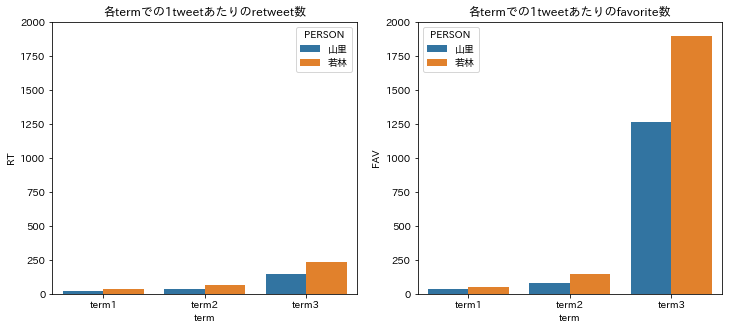

In [27]:
# Displaying the average of retweet and favorite per term and person
plt.figure(figsize = [12, 5])

plt.subplot(1, 2, 1)
sb.barplot(data=df_rt_fav, x='term',y='RT',hue='PERSON')
plt.ylim((0,2000))
plt.title('各termでの1tweetあたりのretweet数')

plt.subplot(1, 2, 2)
sb.barplot(data=df_rt_fav, x='term',y='FAV',hue='PERSON')
plt.ylim((0,2000))
plt.title('各termでの1tweetあたりのfavorite数');

#### Conclusion: Wakabayashi has more retweet and favorite than Yamasato

### Analyzing2. Top5 retweeted per Person and term

In [63]:
from IPython.display import display

In [86]:
for person in ['若林','山里']:
    for term in ['term1', 'term2', 'term3']:
        df_fav_text =df[(df['PERSON']==person)&(df['term']==term)].sort_values('FAV', ascending=False)[['TW_TEXT', 'FAV']].head()
        display(df_fav_text)
        print("term:{}, person{}".format(term,person))

,TW_TEXT,FAV
1701,初めて言ってみよっと。「君、かわうぃーーーね！」文責若林,201
1546,オレ人間不信になりました。文責若林,200
1700,「あげぽよー」っと！文責若林,172
1647,みなさん愛してます(プププ)ライブ楽しんでくださいね(ククク)文責若林,164
1747,では、私は実際にK1のリングに上がった男を召喚しましょうか？文責若林,148


term:term1, person若林


,TW_TEXT,FAV
125,メリークリスマス！このDVDを、あなたの大切な人に…頑張った自分へのご褒美に… 文責若林 http://t.co/pwJY2zET7y,1655
197,チュウ、チュウ。文責悪鼠 http://t.co/p14YvibKcf,773
195,チュウ、チュウ。文責悪鼠 http://t.co/SKT6Xn93il,549
251,イクラの軍艦がハートになってました。気づいたら笑顔になってました。癒されるなー。文責若林 http://t.co/37jE2iSNyj,451
530,去年やった単独ライブでオードリーの漫才にまだ余白があることを発見して、最近はそのことをたまに考えていたので、ここへきての唐突な赤メガネにびっくりしてしまって。文責若林,447


term:term2, person若林


,TW_TEXT,FAV
34,明日以降に情報解禁なのですが、日本一のバトルMC、世界一のバトルDJ、宇宙一の音源でおなじみのCreepy Nutsが、さよならたりないふたりのライブでのみ聴けるヒップホップを提供してくれたらしいです！文責若林,5793
123,毎年誕生日にメールくれるんだよな。怖いなぁ。でも、そういうところかぁ…文責若林,5750
121,そういうとこなんだよね。の説得力が5年前とは桁違いだ。文責若林,3961
60,トゥース！文責若林 https://t.co/ZpZ4rjau0s,3523
82,なんだこの表情の差は！文責若林 https://t.co/FU2sUMRbCk,3094


term:term3, person若林


,TW_TEXT,FAV
1077,祝われちゃった！文責山里 http://t.co/vHqE2xn8,236
1447,若林くんへの悪態なんて思いつかないよ…高い確率で目が死んでるとか、笑い声がほぼ悪魔の時があるとか、心のセキュリティがひどすぎるとか、僕の誘いを断る時の断り方が狂ってるとか、人の失敗をギャグ漫画でも見るような目で見てるときがあるとか、クズ位しか思いつかないです。文責山里,154
1798,『たりないふたり』山里亮太・若林正恭。11月12日。18時開場 18時30分開演。会場:草月ホール:チケットぴあにて10月8日(土)プレリザーブ10月15日(土)一般発売料金:3800円全席指定Pコード:416-067文責山里,129
1676,今日も若林くんは僕を責めたてる…ふと見つけた二年前のたりないふたり初打ち合わせの時の写真に涙…あの頃の若林くんの辞書には「遠慮」という文字があったのに…文責山里 http://t.co/aeg1QkDE,120
1748,チャン若･･･いや、若林くん･･･まぁ落ち着いて！ いざとなったらこちらは国旗を背負った拳を持つ女を召喚することも･･･文責山里,96


term:term1, person山里


,TW_TEXT,FAV
124,若林くんこんな顔できるんだ…ん？目が死んでらぁ…文責山里,335
542,なんかすごい話を聞いたんだけど、若林くんやれる？文責山里,317
540,もう怖い…あの男は、たりないふたりごと忘れてしまったのでは！？そうだ、打ち上げ誘っても「トイストーリーのDVDを観る」を理由に帰ったりする男だからなぁ…文責山里,242
504,そうだね…次の４月から用意された場所は[もっと！たりないふたり]らしいしね。文責山里,196
510,犬は分かるんだよ若林くん。僕も触れ合ってるイルカが途中から体調悪くなった事があるよ。文責山里,184


term:term2, person山里


,TW_TEXT,FAV
122,おめでとうで恐怖を感じられたのは初めてです。なにより若林くん、もう、おめでとうも素直に受け取れなくなってるんだね…そういうとこなんだよね。文責山里,4340
66,たりないふたりのチケットについてのつぶやきを見る、本当にありがたい。当選した人のアカウントを見る、紹介文のところに、高い確率でリトルトゥースという単語が目に飛び込んでくる。まさかアウェイでのぞむことになるのだろうか…文責山里,2387
120,なぁ、もう少し文字に感情込めてもらえないかな？文字から棒読みが伝わってくるのよ文責山里,2041
20,すごい情報解禁なのに、すごさが少し減った…原因はあなたよ若林くん文責山里 https://t.co/pI69UIU1zK,1870
10,繋いでた鎖切りやがったな！やってやるよ、こっちだってな色々思ってるところあるんだよ！カス？カスなめんなよ、待っとけクズ！文責山里,1808


term:term3, person山里


### Analyzing3. The number of tweet per term

KeyError: 0

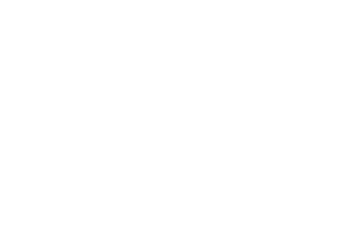

In [80]:
person ='若林'
term ='term1'
df_fav_text =df[(df['PERSON']==person)&(df['term']==term)].sort_values('FAV', ascending=False)[['TW_TEXT', 'FAV']].head()

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

ax.table(ax,df_fav_text)  # where df is your data frame

plt.savefig('mytable.png')

In [33]:
# Creating new DataFrame for counting favorite and retweet average
df_tw_count=df.groupby(['PERSON', 'term'])['TW_NO'].count().reset_index()

# Deleting "不明"(Unknown) and "双方"(both) in person column
df_tw_count =df_tw_count[df_tw_count['PERSON'].isin(['若林','山里'])]

In [34]:
# Check the DataFrame
df_tw_count

,PERSON,term,TW_NO
5,山里,term1,339
6,山里,term2,189
7,山里,term3,57
8,若林,term1,418
9,若林,term2,218
10,若林,term3,65


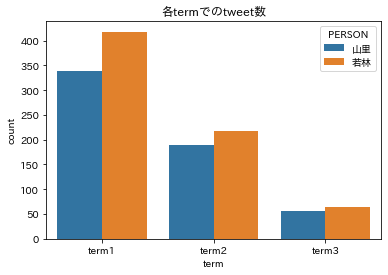

In [35]:
# Show the graph
sb.barplot(data=df_tw_count, x='term',y='TW_NO',hue='PERSON')
plt.ylabel('count')
plt.title('各termでのtweet数');

#### Conclusion: the tweet number is decreasing per term.

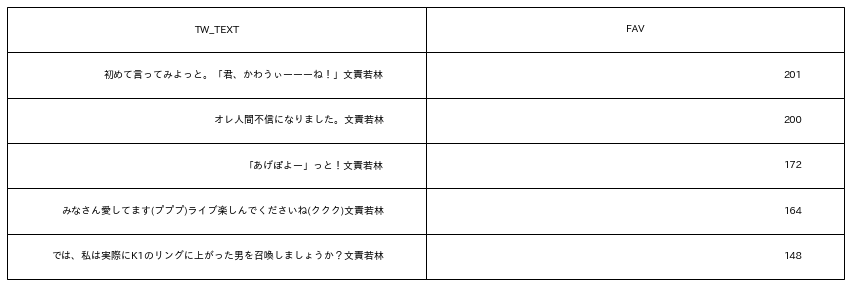

In [29]:
person='若林'
term='term1'
df_fav_text =df[(df['PERSON']==person)&(df['term']==term)].sort_values('FAV', ascending=False)[['TW_TEXT', 'FAV']].head()
fig, ax = plt.subplots(figsize=(15,5))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_fav_text.values,
         colLabels=df_fav_text.columns,
         loc='center',
         bbox=[0,0,1,1])
plt.savefig('table.png')


### Analyzing4. Which word Wakabayashi and Yamasato is using the most frequently?

In [36]:
# setting Mecab
import MeCab

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

df_text_mod = df.copy()

In [37]:
# Delete 文責xx in twitter text
re_person = re.compile('(文責(若林|悪鼠|・若林|若|山里|謎のラッパー|たり林てる恭|逃げ林|デロリアン山里))|(歌責若林)|MASA|山里亮太')
for i in range(df_text_mod.shape[0]):
    df_text_mod.loc[i,'TW_TEXT'] =re_person.sub("",df_text_mod.loc[i,'TW_TEXT'])

In [38]:
# Check the result
df_text_mod[df_text_mod['TW_TEXT'].str.contains('文責')]

,TW_NO,TW_TIME,TW_TEXT,FAV,RT,PERSON,term
1228,185523226238128128,2012-03-30 09:25:58,まだ文責をいじるのか…,21,6,山里,term1
1768,122238042244255744,2011-10-07 18:13:15,いじってないですよ！漫才のためのマススパーです。今日は、会議室がむさ苦しくならないようにコンビニでロールケーキとミルクティー買っていきます。文責の件はすいません、いじってます。。,69,22,若林,term1
1769,122211136211927040,2011-10-07 16:26:20,ほらそこはニュアンスってやつじゃない？的な反論を今夜の打ち合わせでします。あ、あと文責にこだわってんな山里･･･といういじりについてもね。,42,11,山里,term1


In [40]:
# Delete unnecesarry phrase
re_half = re.compile(r'[!-~]')  # 半角記号,数字,英字
re_full = re.compile(r'[︰-＠]')  # 全角記号
re_full2 = re.compile(r'[、・’〜：＜＞＿｜「」｛｝【】『』〈〉“”○〔〕…――――◇～･]')  # 全角で取り除けなかったやつ
re_comma = re.compile(r'[。]')  # 読点のみ
re_url = re.compile(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+')
re_tag = re.compile(r"<[^>]*?>")    #HTMLタグ
re_n = re.compile(r'\n')  # 改行文字

for i in range(df_text_mod.shape[0]):
    for comp in [re_half, re_full, re_full2, re_comma, re_url, re_tag, re_n]:
        df_text_mod.loc[i,'TW_TEXT'] =comp.sub("",df_text_mod.loc[i,'TW_TEXT'])

In [41]:
# Check the result
df_text_mod['TW_TEXT'].head()

0                     さよならいやこんにちは 
1                 ついていくしかないんでしょ行くよ
2    ノートの向こう側に連れて行ってあげるからね楽しみにしててね
3                   ご指示の通りノート見てたから
4             おいこの返しを見るに今日調子良さそうだな
Name: TW_TEXT, dtype: object

In [42]:
# Create Wakabayashi df and Yamasato df per term
df_waka = df_text_mod[df_text_mod['PERSON']=='若林'].reset_index()
df_yama = df_text_mod[df_text_mod['PERSON']=='山里'].reset_index()

In [43]:
df_waka.shape

(701, 8)

In [44]:
# Create dictionary. Key -> Word, Value -> pos
word_dict={}

for i in range(df_waka.shape[0]):
    text = df_waka.loc[i, 'TW_TEXT']
    node = mecab.parseToNode(text)
    while node:
        #単語を取得
        word = node.surface
        #品詞を取得
        pos = node.feature.split(",")[1]
        word_dict[word]=pos
        #次の単語に進める
        node = node.next

In [45]:
word_dict['あと']

'副詞可能'

In [46]:
# Create dictionary. Key -> Word, Value -> word_count

word_count_waka={}

for i in range(df_waka.shape[0]):
    text = df_waka.loc[i, 'TW_TEXT']
    node = mecab.parseToNode(text)
    while node:
        # Get word
        word = node.surface
        # Get pos
        pos = node.feature.split(",")[1]
        if pos in ['固有名詞', '一般', 'サ変接続', '形容動詞語幹']:
            word_count_waka[word]= word_count_waka.get(word, 0) + 1
        # Move to next word
        node = node.next

In [47]:
df_waka_word =pd.DataFrame(word_count_waka.items(), columns=['word','count'])

df_waka_word = df_waka_word.sort_values('count', ascending=False).head(10)

In [48]:
df_waka_word

,word,count
27,山里,204
19,たりないふたり,110
6,山ちゃん,74
138,人,49
9,漫才,37
18,もっと,31
248,収録,24
63,安島,23
55,ライブ,21
133,シャツ,20


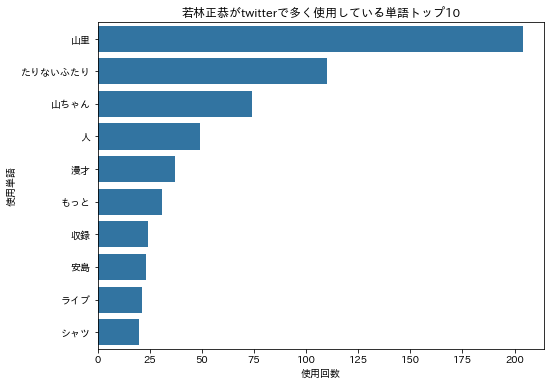

In [49]:
plt.figure(figsize = [8,6])
base_color = sb.color_palette()[0]
sb.barplot(data = df_waka_word, y = 'word', x = 'count', color=base_color)
plt.title('若林正恭がtwitterで多く使用している単語トップ10')
plt.xlabel('使用回数')
plt.ylabel('使用単語');

In [50]:
# Create dictionary. Key -> Word, Value -> word_count
word_count_yama={}

for i in range(df_yama.shape[0]):
    text = df_yama.loc[i, 'TW_TEXT']
    node = mecab.parseToNode(text)
    while node:
        # Get word
        word = node.surface
        # Get pos
        pos = node.feature.split(",")[1]
        if pos in ['固有名詞', '一般', 'サ変接続', '形容動詞語幹']:
            word_count_yama[word]= word_count_yama.get(word, 0) + 1
        # Move to next word
        node = node.next

In [51]:
df_yama_word =pd.DataFrame(word_count_yama.items(), columns=['word','count'])

df_yama_word = df_yama_word.sort_values('count', ascending=False).head(10)
df_yama_word

,word,count
47,若林くん,226
29,たりないふたり,64
90,若林,41
378,打ち合わせ,25
522,皆様,23
109,人,21
241,自分,20
73,山里,19
105,顔,17
116,目,17


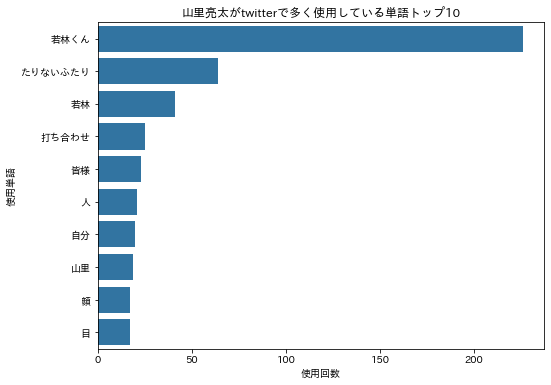

In [52]:
plt.figure(figsize = [8,6])
base_color = sb.color_palette()[0]
sb.barplot(data = df_yama_word, y = 'word', x = 'count', color=base_color)
plt.title('山里亮太がtwitterで多く使用している単語トップ10')
plt.xlabel('使用回数')
plt.ylabel('使用単語');

### Analyzing5. Word count per tweet

In [53]:
df_wc= df_text_mod[df_text_mod['PERSON'].isin(['若林','山里'])].sort_values('term')

In [54]:
# Create word_count column
df_wc['word_count']= df_wc['TW_TEXT'].apply(lambda x: len(x))

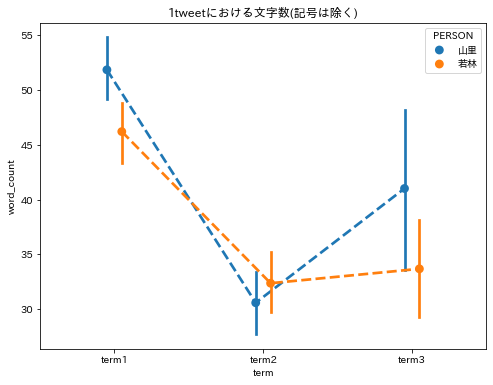

In [55]:
# Create graph
plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_wc, x = 'term', y = 'word_count',
                  hue = 'PERSON', dodge = 0.1, linestyles = "--")
plt.title('1tweetにおける文字数(記号は除く)');

#### Conclusion: The word per tweet of Wakabayashi is decreasing per term. 
#### Conclusion: The word per tweet of Yamasato is stable. 